# Cargue y preentrenamiento de datos

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas


In [2]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


{'Basket': {(255, 255), (256, 256)},
 'Campo_Futbol': {(255, 255), (256, 256)},
 'Cancha_Micro': {(255, 255), (256, 256), (4080, 4080)},
 'Cancha_Multiple': {(255, 255), (256, 256), (4080, 4080)},
 'Parque': {(255, 255), (256, 256)},
 'Tenis': {(255, 255), (256, 256)}}

In [3]:
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

C:\Users\nicol\AppData\Local\Temp\ipykernel_33232\279961940.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.


In [4]:
# Codificar las etiquetas
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Micro': 2, 'Cancha_Multiple': 3, 'Parque': 4, 'Tenis': 5}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 282, 1: 252, 2: 272, 3: 266, 4: 244, 5: 260}


In [5]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 282, 1: 282, 2: 282, 3: 282, 4: 282, 5: 282}


In [6]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 1576
Número de ejemplos de entrenamiento después del balanceo: 1692
Número de ejemplos de prueba: 395


# Entrenamiento modelo customizado

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(6, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,870 (60.14 MB)

 Trainable params: 15,764,870 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 797ms/step - accuracy: 0.2900 - loss: 1.9725 - val_accuracy: 0.5751 - val_loss: 1.0303
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.5756 - loss: 0.9869 - val_accuracy: 0.7376 - val_loss: 0.6628
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 744ms/step - accuracy: 0.7401 - loss: 0.6258 - val_accuracy: 0.8339 - val_loss: 0.4583
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 717ms/step - accuracy: 0.8251 - loss: 0.4284 - val_accuracy: 0.8723 - val_loss: 0.3026
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 715ms/step - accuracy: 0.8569 - loss: 0.3176 - val_accuracy: 0.8717 - val_loss: 0.2900
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 706ms/step - accuracy: 0.8683 - loss: 0.2641 - val_accuracy: 0.8883 - val_loss: 0.2129
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - accuracy: 0.8667 - loss: 0.2385 - val_accuracy: 0.8865 - val_loss: 0.2106
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 719ms/step - accuracy: 0.8697 - loss: 0.2272 - val_accu

In [9]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.4865 - loss: 1.5156


In [10]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Micro', 'Cancha_Multiple', 'Parque', 'Tenis']))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Precision: 0.5086411075062318
Recall: 0.49873417721518987
F1 Score: 0.5023730284658321
Accuracy: 0.49873417721518987
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.46      0.51      0.49        76
   Campo_Futbol       0.27      0.23      0.25        64
   Cancha_Micro       0.05      0.06      0.06        47
Cancha_Multiple       0.57      0.50      0.53        62
         Parque       0.78      0.82      0.80        84
          Tenis       0.71      0.65      0.68        62

       accuracy                           0.50       395
      macro avg       0.48      0.46      0.47       395
   weighted avg       0.51      0.50      0.50       395



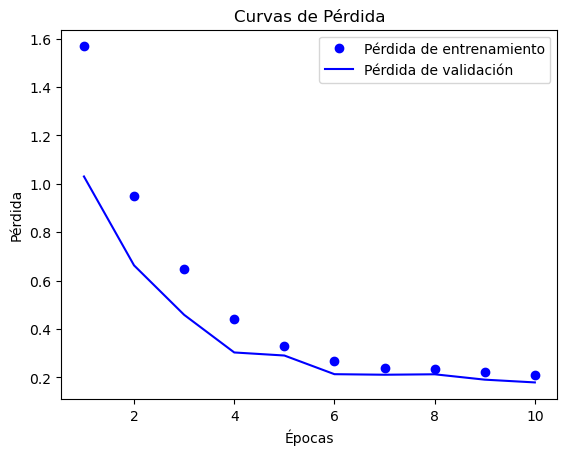

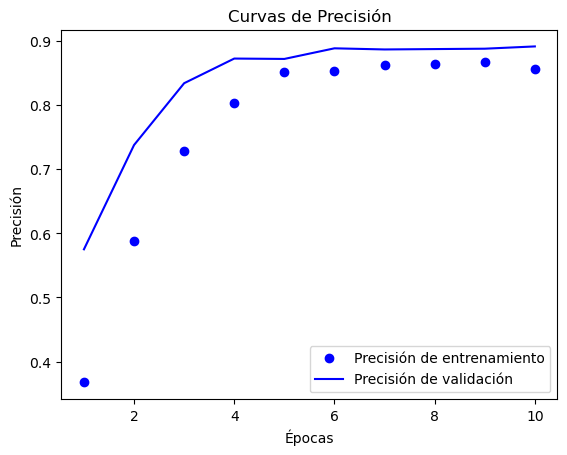

In [11]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [12]:
# Abrir la imagen
#imagen = Image.open('C:/Users/nicol/Desktop/Datasets/Dota2/part2-001/images/P1105.png')

# Redimensionar la imagen a 256x256
#imagen_redimensionada = imagen.resize((256, 256))

# Convertir la imagen redimensionada a un arreglo (matriz) y normalizarla
#imagen_arreglo = np.array(imagen_redimensionada) / 255.0

# Agregar una dimensión adicional para representar el lote
#imagen_arreglo = np.expand_dims(imagen_arreglo, axis=0)

In [13]:
# Realizar predicciones
#predicciones = modelo.predict(imagen_arreglo)

# Interpretar las predicciones
#clase_predicha = np.argmax(predicciones, axis=1)

# Visualizar resultados (opcional)
#print("Predicciones:", clase_predicha)


# Entrenamiento con VGG16

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [15]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.2398 - loss: 3.7256 - val_accuracy: 0.5165 - val_loss: 1.3186
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.4002 - loss: 1.3527 - val_accuracy: 0.5291 - val_loss: 1.0830
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.4265 - loss: 1.2170 - val_accuracy: 0.5595 - val_loss: 0.9542
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.4529 - loss: 1.1344 - val_accuracy: 0.5418 - val_loss: 0.9407
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.4787 - loss: 1.0744 - val_accuracy: 0.6076 - val_loss: 0.8901
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5247 - loss: 1.0058 - val_accuracy: 0.6354 - val_loss: 0.8657
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.4998 - loss: 0.9799 - val_accuracy: 0.6608 - val_loss: 0.8818
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5421 - loss: 0.9378 - val_accuracy: 0.6506 - v

In [16]:

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Micro', 'Cancha_Multiple', 'Parque', 'Tenis']))

13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Precision: 0.5742380570630847
Recall: 0.6354430379746835
F1 Score: 0.5947924424383415
Accuracy: 0.6354430379746835
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.65      0.66      0.65        76
   Campo_Futbol       0.00      0.00      0.00        64
   Cancha_Micro       0.36      0.79      0.50        47
Cancha_Multiple       0.60      0.66      0.63        62
         Parque       0.96      0.90      0.93        84
          Tenis       0.68      0.76      0.72        62

       accuracy                           0.64       395
      macro avg       0.54      0.63      0.57       395
   weighted avg       0.57      0.64      0.59       395



c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packag

# Entrenamiento con Resnet50

In [19]:
from tensorflow.keras.applications import ResNet50

# Cargar el modelo ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x) 


In [20]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1444 - loss: 13.2648 - val_accuracy: 0.0154 - val_loss: 2.0786
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1294 - loss: 2.1279 - val_accuracy: 0.0154 - val_loss: 2.0802
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1327 - loss: 2.0983 - val_accuracy: 0.0154 - val_loss: 2.0804
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.1220 - loss: 2.0796 - val_accuracy: 0.0154 - val_loss: 2.0802
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1159 - loss: 2.0795 - val_accuracy: 0.0154 - val_loss: 2.0801
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1095 - loss: 2.0798 - val_accuracy: 0.0154 - val_loss: 2.0797
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.1117 - loss: 2.0795 - val_accuracy: 0.0154 - val_loss: 2.0798
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1120 - loss: 2.0795 - val_accuracy: 0.0154 - val_loss

In [21]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Micro', 'Cancha_Multiple', 'Parque', 'Tenis']))

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002389B1F5040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Precision: 0.0002366863905325444
Recall: 0.015384615384615385
F1 Score: 0.0004662004662004662
Accuracy: 0.015384615384615385
Classification Report:
                 precision    recall  f1-score   suppo

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packag

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [23]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # Suponiendo 5 clases

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [26]:
# Número de épocas
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')



Epoch 1, Loss: 2.102822095155716
Epoch 2, Loss: 1.719029426574707
Epoch 3, Loss: 1.4277747670809429
Epoch 4, Loss: 1.2649567027886708
Epoch 5, Loss: 1.1135799835125606
Epoch 6, Loss: 1.0059785097837448
Epoch 7, Loss: 0.9293568730354309
Epoch 8, Loss: 0.8374169617891312
Epoch 9, Loss: 0.792099247376124
Epoch 10, Loss: 0.7698967854181925


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 50.76923%
Precision: 0.51001
Recall: 0.50769
F1 Score: 0.48315


c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Modelo Preentrenado Xception con ImageNet

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [11]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3449 - loss: 8.7244 - val_accuracy: 0.3846 - val_loss: 3.2664
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5666 - loss: 2.4168 - val_accuracy: 0.5077 - val_loss: 1.4613
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5593 - loss: 1.3015 - val_accuracy: 0.4308 - val_loss: 1.7092
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5862 - loss: 1.1705 - val_accuracy: 0.4769 - val_loss: 1.6791
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6088 - loss: 1.0521 - val_accuracy: 0.3692 - val_loss: 1.6546
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6913 - loss: 0.8884 - val_accuracy: 0.4308 - val_loss: 1.4917
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7109 - loss: 0.7443 - val_accuracy: 0.4615 - val_loss: 1.4899
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7543 - loss: 0.7193 - val_accuracy: 0.4308 - val_loss:

In [12]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Micro', 'Cancha_Multiple', 'Parque', 'Tenis']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Precision: 0.4053724053724054
Recall: 0.4307692307692308
F1 Score: 0.3972649572649572
Accuracy: 0.4307692307692308
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.22      0.18      0.20        11
        Beisbol       0.00      0.00      0.00         1
   Campo_Futbol       0.61      0.92      0.73        12
   Cancha_Micro       0.33      0.22      0.27         9
Cancha_Multiple       0.14      0.09      0.11        11
         Parque       0.38      0.75      0.50         8
 Pista Patinaje       0.00      0.00      0.00         1
          Tenis       0.75      0.50      0.60        12

       accuracy                           0.43        65
      macro avg       0.30      0.33      0.30        65
   weighted avg       0.41      0.43      0.40        65



c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packag

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
batch_size = 32
learning_rate = 0.01

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)

model = model.to(device)


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


Epoch 1, Loss: 1.7694284151185233


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 77.46835%
Precision: 0.79184
Recall: 0.77468
F1 Score: 0.73625


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)

model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Definir el scheduler para reducir la tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Ajustar la tasa de aprendizaje
    scheduler.step(running_loss / len(trainloader))
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluación del modelo
model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')


Epoch 1, Loss: 0.9699384125898469
Epoch 2, Loss: 0.5206811248131518
Epoch 3, Loss: 0.466607522289708
Epoch 4, Loss: 0.39079675162738226
Epoch 5, Loss: 0.3189254681456764
Epoch 6, Loss: 0.36384853748780377
Epoch 7, Loss: 0.3233236425890113
Epoch 8, Loss: 0.37607850021911116
Epoch 9, Loss: 0.2572533204308096
Epoch 10, Loss: 0.23107720264848672
Epoch 11, Loss: 0.23547396977555077
Epoch 12, Loss: 0.2316109209128146
Epoch 13, Loss: 0.21686679996409505
Epoch 14, Loss: 0.22338296121583795
Epoch 15, Loss: 0.21655646303914627
Accuracy: 80.00000%
Precision: 0.79370
Recall: 0.80000
F1 Score: 0.79669


In [13]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/DBPropio_mobileNET.pth')